
 set|  max strokes length| avg strokes length
--|--|--
training set (0+1)|289|14
validation set (2)|233|
test set (3) |218|

trim data at 288 because 289 is only divisible by 17 which is a primary number so it's not convenient in regards to pooling

In [1]:
#smart manuscript
from smartmanuscript.corpus_iam import _import_set

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})#for prettier plots
#math tools
import numpy as np
#preprocessing
from sklearn.preprocessing import scale
#machine learning
import torch
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("using",device,"device")
#io
from os.path import join
from os.path import exists
from os import makedirs
from os import listdir
import pickle
import sys
sys.path.append("..")
#utils
from time import time
import warnings
#custom
from parkinson_detection.modules.utils import *

using cuda device


# Utils

In [2]:
def plot(plot_i,train,valid,test):
    plt.title(model_name)
    plt.plot(train,label="training")
    if valid is not None:
        plt.plot(valid,label="validation")
    plt.plot(test,label="test")
    plt.xlabel("epochs")
    plt.ylabel(index2plot[plot_i])
    plt.legend()
    if plot_i!=0:
        plt.ylim(0,1)

def plot_measures(task,subplot=True,figsize=(16,12)):
    plt.figure(figsize=figsize)
    for i,measure in enumerate(index2measure):
        if subplot:
            plt.subplot(3,3,i+1)
        plt.plot(task[:,i])
        plt.xlabel("timesteps")
        plt.ylabel(measure)

# Data loading

In [3]:
set_numbers=[0,1,2,3,4]
set_number=set_numbers[2]
assert set_number in set_numbers
iamondo_path=join("data","IAMonDo-db-1.0")
max_len=288
measure2index={"y-coordinate":0,"x-coordinate":1}
index2measure=list(measure2index.keys())

In [4]:
if False:    
    if False:        
        words, lines = _import_set(iamondo_path, "{}.set".format(set_number), max_files=None)

        data=np.asarray([stroke for word in words for stroke in  word[1]])
    else:
        print("loading raw data")
        data=np.load(join("data","0_1.set.npy"))
        print("raw data shape",data.shape)
    print("scaling and padding data at",max_len)
    tmp=[]
    for stroke in data:
        stroke=scale(stroke,axis=0)
        if len(stroke) > max_len:
            stroke=stroke[:max_len]
        else:
            stroke=np.concatenate((stroke,np.zeros(shape=(max_len-len(stroke),stroke.shape[1]))))#zero-padding
        tmp.append(stroke)
    data=np.asarray(tmp)
    print("data.shape",data.shape)
    np.save("data/padded_0_1.set.npy",data)
else:
    print("loading scaled and padded data")
    train_set=np.load(join("data","padded_0_1.set.npy"))
    test_set=np.load(join("data","padded_3.set.npy"))
    #reverse x and y column to match PaHaW
    train_set=train_set[:,:max_len,::-1]
    test_set=test_set[:,:max_len,::-1]
    print("train_set.shape",train_set.shape)
    print("test_set.shape",test_set.shape)

loading scaled and padded data
train_set.shape (114564, 288, 2)
test_set.shape (57562, 288, 2)


#  Model

https://pytorch.org/docs/stable/nn.html#convtranspose1d

In [5]:
import torch

class CNNAutoencoder(torch.nn.Module):
    def __init__(self,input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                 stride=1,dilation=1, dropout=0.0,input_noise=0.0):
        super(CNNAutoencoder, self).__init__()
        self.num_layers=len(hidden_size) 
        
        self.noise=torch.nn.Dropout(input_noise)
        layers=[]
        for i, (h,c,p,pad) in enumerate(list(zip(hidden_size,conv_kernel,pool_kernel,padding))):
            s = input_size if i ==0 else hidden_size[i-1]
            layers+=[
                torch.nn.Conv1d(s,h,c,stride=1,padding=pad,dilation=1),
                torch.nn.MaxPool1d(p),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout)
            ]
        self.encoder=torch.nn.Sequential(*layers)
        
        layers=[]
        for i, (h,c,p,pad) in enumerate(list(zip(hidden_size,conv_kernel,pool_kernel,padding))[::-1]):
            if i ==self.num_layers-1:                
                s= input_size
                layers+=[
                    torch.nn.ConvTranspose1d(h,s,c,stride=p,padding=0,dilation=1)
                ]
            else :
                s = hidden_size[::-1][i+1]      
                layers+=[
                    torch.nn.ConvTranspose1d(h,s,c,stride=p,padding=0,dilation=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(dropout)
                ]        
        self.decoder=torch.nn.Sequential(*layers)
        
    def forward(self,subject):
        noisy=self.noise(subject)
        code=self.encoder(noisy)
        decode=self.decoder(code)        
        return code,decode#self.sigmoid(d_c1)


# Training def


In [6]:
def kl_divergence(p, q):
    '''
    args:
        2 tensors `p` and `q`
    returns:
        kl divergence between the softmax of `p` and `q`
    '''
    p = torch.nn.functional.softmax(p,dim=0)
    q = torch.nn.functional.softmax(q,dim=0)

    s1 = torch.sum(p * torch.log(p / q))
    s2 = torch.sum((1 - p) * torch.log((1 - p) / (1 - q)))
    return s1 + s2

In [7]:
def step(input, target, model, optimizer, loss_fn, batch_size,validation = False, device="cuda"):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()

    # Set device options
    input=input.to(device)
    target=target.to(device)
    #forward pass
    code,decode=model(input)

    # Compute loss
    loss = loss_fn(decode, target)#MSE
    #rho_hat = torch.sum(code, dim=0, keepdim=True)
    #sparsity_penalty = BETA * kl_divergence(rho, code)
    #loss+=sparsity_penalty
    if not validation:
        # Perform backpropagation
        loss.backward()
        # Adjust model weights
        optimizer.step()
    return loss.item(), decode.squeeze().cpu().detach().numpy()

#  Hyperparameters

In [13]:
dropout=0.0
input_noise=0.5
RHO = 0.01
BETA = 3
hidden_size=[16,32,64]  
conv_kernel= [8,4,3]
pool_kernel=conv_kernel#[8,4,3]
assert (max_len/np.prod(pool_kernel))%1==0
dilation= 'redef as 1'#[1,1]
stride='redef as kernel_size'
output_size="foo"
padding=[]
for d,k in list(zip(dilation,conv_kernel)):
    padding.append(k//2)#d*(k-1)//2
input_size=2
batch_size=64
loss_fn=torch.nn.MSELoss()

learning_rate=1e-3
verbose=False
model_type="CNNAutoencoder"

model_name=str((model_type,learning_rate,hidden_size, dropout, conv_kernel,pool_kernel,dilation,input_noise,"actual_pooling"))

rho=torch.zeros((batch_size,hidden_size[-1],int(max_len/np.prod(pool_kernel))),device=device)
rho=rho.add(RHO)

In [14]:
torch.manual_seed(1)
model=CNNAutoencoder(input_size,hidden_size,conv_kernel,pool_kernel ,padding,stride,dilation, dropout,input_noise)

model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
print(count_params(model))
print(model)
start = time()
train_loss,test_loss=[],[]
for epoch in range(50):
    np.random.seed(1)
    np.random.shuffle(train_set)#shuffle train_set to facilitate SGD
    
    #training
    model.train()
    batch_loss=0
    for batch_i in range(0,len(train_set),batch_size):
        batch=torch.Tensor(train_set[batch_i:batch_i+batch_size].copy()).transpose(1,2)
        loss,output=step(batch, batch, model, optimizer, loss_fn, batch_size,False,device)
        batch_loss+=loss
    train_loss.append(batch_loss/(len(train_set)//batch_size))
    
    #testing
    model.eval()
    batch_loss=0
    for batch_i in range(0,len(test_set),batch_size):
        batch=torch.Tensor(test_set[batch_i:batch_i+batch_size].copy()).transpose(1,2)
        loss,output=step(batch, batch, model, optimizer, loss_fn, batch_size,True,device)
        batch_loss+=loss
    test_loss.append(batch_loss/(len(test_set)//batch_size))
    if verbose:
        print(epoch,train_loss[-1],test_loss[-1])

print("Done. Spent",timeSince(start))

(17058, 17058)
CNNAutoencoder(
  (noise): Dropout(p=0.5)
  (encoder): Sequential(
    (0): Conv1d(2, 16, kernel_size=(8,), stride=(1,), padding=(4,))
    (1): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.0)
    (4): Conv1d(16, 32, kernel_size=(4,), stride=(1,), padding=(2,))
    (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Dropout(p=0.0)
    (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): Dropout(p=0.0)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(3,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): ConvTranspose1d(16, 2, kernel_size=(8,), stride=(8,))
  )
)


In [100]:
batch=torch.Tensor(test_set[0:0+batch_size].copy()).transpose(1,2).to(device)

code,decode=model(batch.to(device))

rho_hat = torch.sum(code, dim=0, keepdim=True)

sparsity_penalty = BETA * kl_divergence(rho, rho_hat)

torch.nn.functional.kl_div(rho, rho_hat)

torch.nn.functional.softmax(rho,dim=0)

In [12]:
if True:
    directory = join("weights", model_name)
    if not exists(directory):
        makedirs(directory)
    torch.save({
        'epoch': epoch,
        'model': model.state_dict(),
        'opt': optimizer.state_dict(),
        'loss': test_loss[-1]
    }, join(directory, '{}_checkpoint.tar'.format(epoch)))
    print("succesfully saved",model_name)
else:
    warnings.warn("did nothing")


succesfully saved ('CNNAutoencoder', 0.001, [16, 32, 64], 0.0, [8, 4, 3], [8, 4, 3], 'redef as 1', 0.0, 'actual_pooling')


# actual pooling

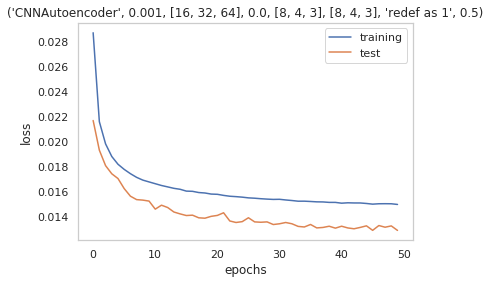

In [98]:
plot(0,train_loss,None,test_loss)

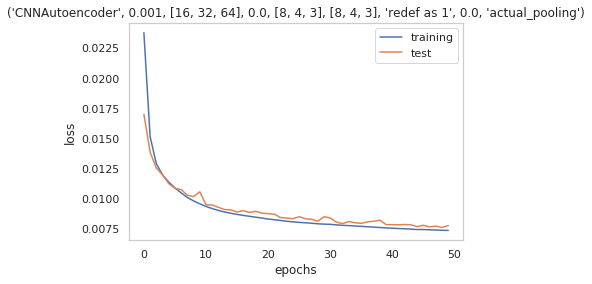

In [120]:
plot(0,train_loss,None,test_loss)

# strided conv (no pooling)
##  dae

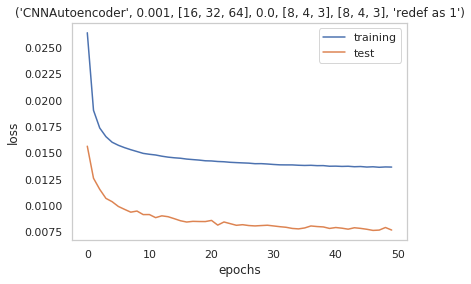

In [235]:
plot(0,train_loss,None,test_loss)

##  vanilla ae

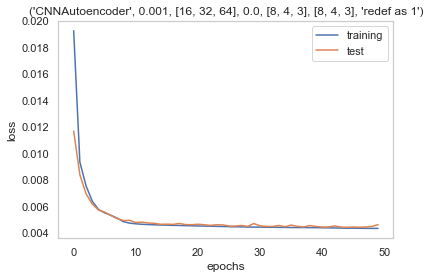

In [83]:
plot(0,train_loss,None,test_loss)

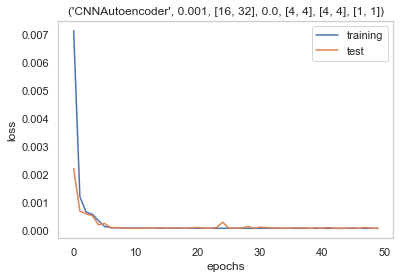

In [42]:
plot(0,train_loss,None,test_loss)

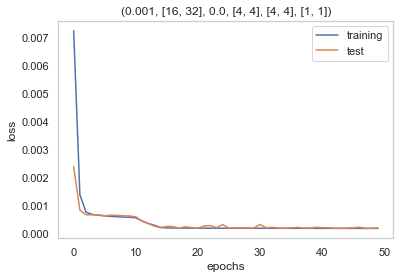

In [116]:
plot(0,train_loss,None,test_loss)

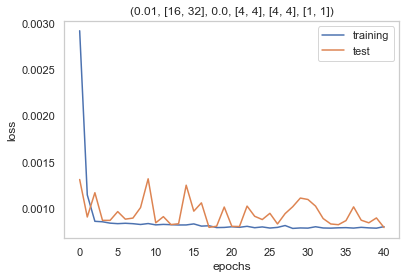

In [106]:
plot(0,train_loss,None,test_loss)

In [123]:
batch=torch.Tensor(test_set[0:0+batch_size,:,:].copy()).transpose(1,2)
loss,output=step(batch, batch, model, optimizer, loss_fn, batch_size,True,device)

In [105]:
trim_to=50

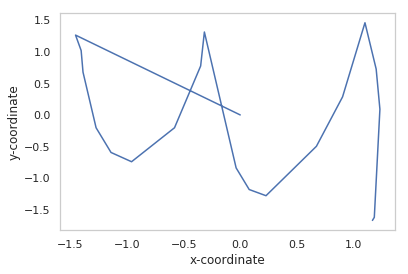

In [106]:
plot_task(test_set[30,:trim_to])

Text(0.5, 1.0, "('CNNAutoencoder', 0.001, [16, 32, 64], 0.0, [8, 4, 3], [8, 4, 3], 'redef as 1', 0.0, 'actual_pooling')")

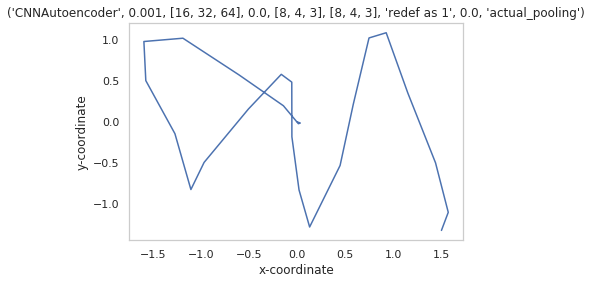

In [124]:
plot_task(output[30].T[:trim_to])#good batch
plt.title(model_name)

Text(0.5, 1.0, "reversed('CNNAutoencoder', 0.001, [16, 32, 64], 0.0, [8, 4, 3], [8, 4, 3], 'redef as 1', 0.0, 'actual_pooling')")

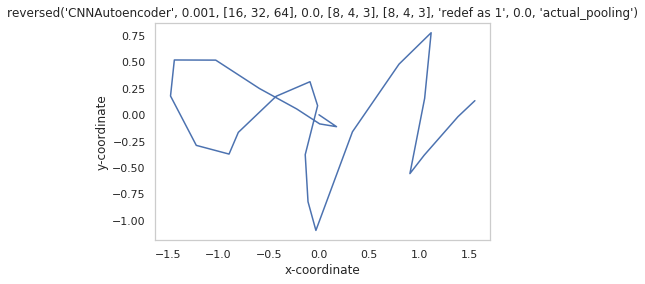

In [122]:
plot_task(output[30].T[:trim_to,::-1])#reversed x and y (flipped back for plotting)
plt.title("reversed"+model_name)

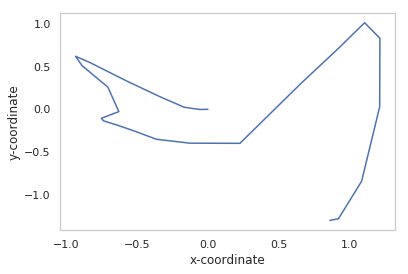

In [107]:
plot_task(output[30].T[:trim_to])#good batch

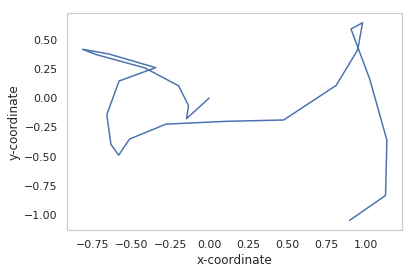

In [116]:
plot_task(output[30].T[:trim_to,::-1])#reversed x and y (flipped back for plotting)

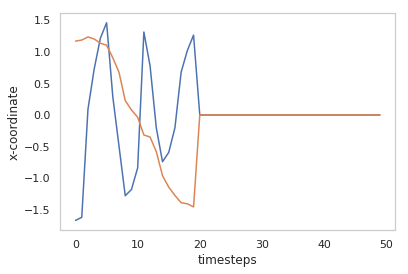

In [110]:
plot_measures(test_set[30,:trim_to],False,(6,4))

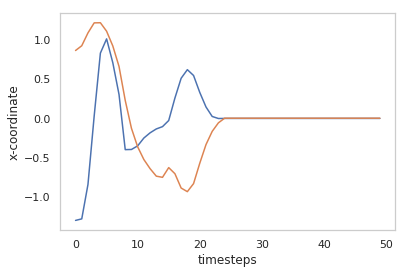

In [111]:
plot_measures(output[30].T[:trim_to],False,(6,4))#good batch

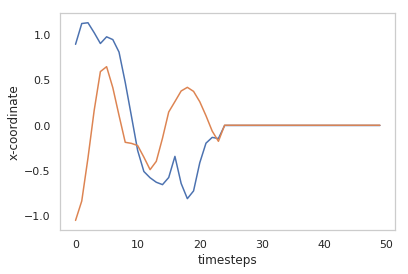

In [114]:
plot_measures(output[30].T[:trim_to],False,(6,4))#rev x and y

In [249]:
c1=model.encoder[0](batch.to(device))
r1=model.encoder[1](c1)
c2=model.encoder[3](r1)
r2=model.encoder[4](c2)
c3=model.encoder[6](r2)
r3=model.encoder[7](c3)
dc1=model.decoder[0](r3)
dr1=model.decoder[1](dc1)
dc2=model.decoder[3](dr1)
dr2=model.decoder[4](dc2)
dc3=model.decoder[6](dr2)

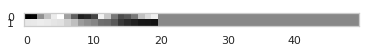

In [250]:
plt.imshow(test_set[30,:trim_to].T,cmap="gray")

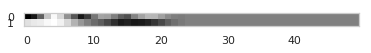

In [252]:
plt.imshow(dc3.detach().cpu().numpy()[30,:,:trim_to],cmap="gray")

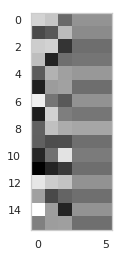

In [253]:
plt.imshow(c1.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

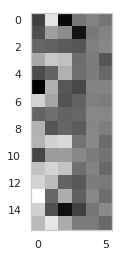

In [254]:
plt.imshow(dc2.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

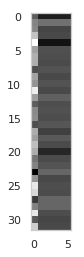

In [255]:
plt.imshow(c2.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

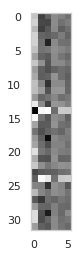

In [256]:
plt.imshow(dc1.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

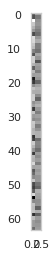

In [257]:
plt.imshow(c3.detach().cpu().numpy()[30,:,:trim_to//8],cmap="gray")

In [36]:
model

CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(2, 16, kernel_size=(8,), stride=(8,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(3,))
    (7): ReLU()
    (8): Dropout(p=0.0)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(3,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): ConvTranspose1d(16, 2, kernel_size=(8,), stride=(8,))
  )
)

In [41]:
c1=model.encoder(batch.to(device))

In [31]:
c1.shape

torch.Size([64, 16, 36])

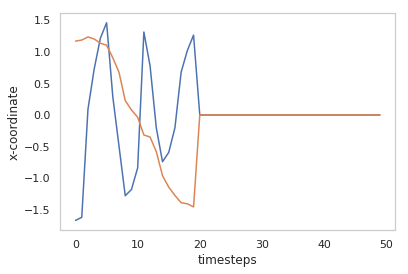

In [260]:
plot_measures(test_set[30,:trim_to],False,(6,4))

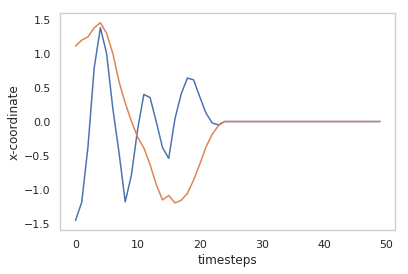

In [261]:
plot_measures(output[30].T[:trim_to],False,(6,4))

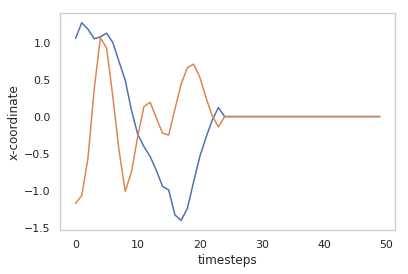

In [263]:
plot_measures(output[30].T[:trim_to],False,(6,4))

# forward pass without activation & dropout

In [82]:
batch=batch.to(device)#torch.Size([64, 2, 288])

c1=model.encoder[0](batch)#torch.Size([64, 16, 289])

p1=model.encoder[1](c1)#torch.Size([64, 16, 36]) : throws out the 289th point (zero padded) 

c2=model.encoder[4](p1)#torch.Size([64, 32, 37])

p2=model.encoder[5](c2)#torch.Size([64, 32, 9]) : throws out the 37th point (zero padded) 

c3=model.encoder[8](p2)#torch.Size([64, 64, 9]) : odd kernel size -> no extra point

p3=model.encoder[9](c3)#torch.Size([64, 64, 3])


dc1=model.decoder[0](p3)#torch.Size([64, 32, 9])

dc2=model.decoder[3](dc1)#torch.Size([64, 16, 36])

dc3=model.decoder[6](dc2)#torch.Size([64, 2, 288])

torch.Size([64, 64, 3])